<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/00_NN_Basics_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks, Plumbing and Colours: Solution notebook

Notebook for DSECOP Module 1

Author: Karan Shah

In this notebook, we learn about the basics of neural networks and train our network to convert colours.

In [1]:
# Get res dir and helper files
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Colab detected. (Re)Loading helper files")
    os.system("rm -rf res")
    os.system("rm -f res.tar.gz")
    os.system("wget https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res.tar.gz?raw=true")
    os.system("mv res.tar.gz?raw=true res.tar.gz")
    os.system("tar -xzf res.tar.gz")

Colab detected. (Re)Loading helper files


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from ipywidgets import interact

import sys
sys.path.insert(1, './res')
try:
    from ml_helper import *
except Exception as e:
    print(e)
    print("ERROR: It seems the ml_helper file is missing. If you are running this in google colab, please run the first cell block again. (Begins with comment: \"Get res dir and helper files\'")


torch.set_default_tensor_type(torch.DoubleTensor)

## So what is machine learning?

Machine learning is a field of computer scince that deals with creating programs that can learn from experience tasks that are not explicitly hardcoded in them. For example, we can create a model that can learn to differentiate between a picture of a cat and a dog without explicit definition of what a cat or a dog is, just by repeteadly looking at pictures which have a correct label on them.

> Machine learning is the study of computer algorithms that allow computer programs to automatically improve through experience.

In this notebook, we will focus on a specific class of ML known as ddeep learning. Deep learning involves the use of models called neural networks. A neural network is loosely inspired by biological neurons in our brains. 

But first, let's take a brief detour into the world of digital colours:

### RGB Colours

Let's understand how computers represent colours. Each pixel on your screen is made of 3 sub-pixels: Red, Green and Blue. By changing the intensities of these sub-pixels, we can generate different colours. This way of representing coulours is called "additive". This is different from the colours that we use while painting, which is "subtractive". When dealing with paints and printing, with subtractive colours, the absence of any colour is white on a sheet of paper. When dealing with digital screens and light, with additive colours, the absence of any colour is black on a display.

![res/fig/rgb-additive-subtractive-colors.jpeg](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/rgb-additive-subtractive-colors.jpeg?raw=1)


Let's play with the RGB colour scheme:
For each colour sub-pixel, the intensity is represented as an integer value between 0 to 255. For convenience, we will represent that as a continuous value between 0.0 to 1.0.

Each colour is represented as a list of subpixels.
[r,g,b] where r is the value of Red subpixel, g is the value of Green subpixel and b is the value of Blue subpixel.


Throughout this notebook, you can call the `viz_colour` function to display the r,g,b values and the resultant colours.
For example, this is how you would represent pure red colour:


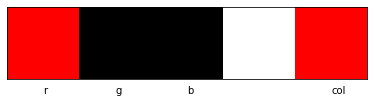

r = 1.0, g = 0.0, b = 0.0


In [3]:
# represent colour as [r,g,b], call the function viz_colour to show the colour.
red = [1.0,0,0]
viz_colour_rgb(red)

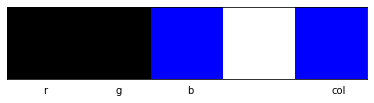

r = 0.0, g = 0.0, b = 1.0


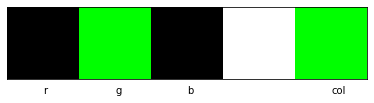

r = 0.0, g = 1.0, b = 0.0


In [4]:
# exercise: fill the values and display blue and green colours
blue = [0.0,0.0,1.0] #fill here
viz_colour_rgb(blue)

green = [0.0,1.0,0.0] #fill here
viz_colour_rgb(green)


We can change the rgb values to create new colours. Refer to figure 1. to see how colours can be mixed. For example, cyan can be made by setting b and g on and turning r off.

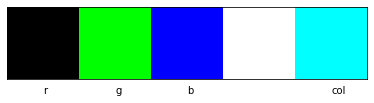

r = 0.0, g = 1.0, b = 1.0


In [5]:
# represent colour as [r,g,b], call the function viz_colour to show the colour.
cyan = [0.0,1.0,1.0]
viz_colour_rgb(cyan)

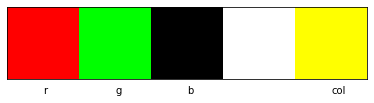

r = 1.0, g = 1.0, b = 0.0


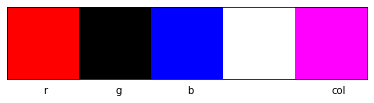

r = 1.0, g = 0.0, b = 1.0


In [6]:
# Exercise: refer to figure 1 and fill the values and display yellow and pink colours
yellow = [1.0,1.0,0.0] #fill here
viz_colour_rgb(yellow)

pink = [1.0,0.0,1.0] #fill here
viz_colour_rgb(pink)


The values of r,g,b can be any number between 0.0 and 1.0 and it represents the intensity of that sub-pixel. For example, compare bright red and dull red

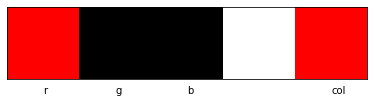

r = 1.0, g = 0.0, b = 0.0


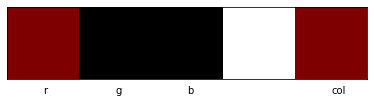

r = 0.5, g = 0.0, b = 0.0


In [7]:
red = [1.0,0.0,0.0]
viz_colour_rgb(red)

dull_red = [0.5,0.0,0.0]
viz_colour_rgb(dull_red)



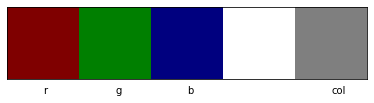

r = 0.5, g = 0.5, b = 0.5


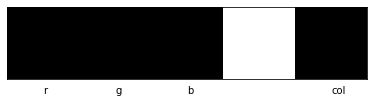

r = 0.0, g = 0.0, b = 0.0


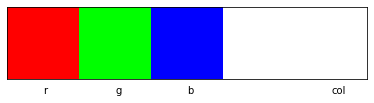

r = 1.0, g = 1.0, b = 1.0


In [8]:
# Exercise: fill the values and display grey colour
grey = [0.5,0.5,0.5] #fill here
viz_colour_rgb(grey)

#black and white for comparison, don't change this 
black = [0.0,0.0,0.0]
viz_colour_rgb(black)

white = [1.0,1.0,1.0]
viz_colour_rgb(white)

You now know how computers represent and display colours! You can play with these sliders and create even more colours:

In [9]:
@interact(r=(0, 1.0),g=(0,1.0),b=(0,1.0))
def interactive_viz_colour(r,g,b):
    c=[r,g,b]
    viz_colour_rgb(c)

interactive(children=(FloatSlider(value=0.5, description='r', max=1.0), FloatSlider(value=0.5, description='g'…

### Neural Networks

We will construct our own neural network bit by bit. Let's begin with an analogy. Imagine we have water with different colours, and we want to add them together to make new colours. We do that by setting up a system of pipes but we do not know how to arrange these pipes. We will invent a robot plumber called PlumberBot who will keep trying different combinations of pipes. 


Lets start with the components of a deep learning pipeline:

1. Set the pipes for the input and the output.
2. Connect the input and output pipes randomly. At this point, the colours will mix incorrectly and we will get wrong results.
3. Compare the colours from the output pipes and the true value that we want.
4. Based on the difference of these colours, adjust the thickness of the pipes by a tiny bit.
5. Repeat steps 3 and 4 till the difference between the predicted colours and the true colours is as low as we want.
6. Now the machine learning pipeline is trained. We can use it to mix the colours very quickly.


Let's look at the parts of this pipeline in detail:

####  Inputs and outputs:
The inputs and outputs represent our quantities of interest. In this notebook, we will represent the input with $x$ and the output with $y$. $x$ and $y$ are vectors. 

The relationship between $x$ and $y$ is
$$ y = f(x) $$
where $f$ is a function acting on $x$. We might not know the function $f$ explicitly, but given enough pairs of corresponding inputs and outputs, the neural network can approximate $f$.

The dataset is the collection of all ($x$,$y$) pairs. We represent the $i$th element of the dataset with the subscript $i$. This means
$$ y_i = f(x_i) $$

Examples:
For a network doing handwriting recognition, $x$ can be an image of written text and $y$ can be the text encoded in digital form.

For a network doing text to speech, $x$ can be a sentence in text form and $y$ can be an audio file.

For a network identifying animals, $x$ can be an image of an animal and $y$ the name of animal in text form.

(In all cases, things such as images, audio, text etc are represented as numbers in computers, so $x$ and $y$ are still vectors)

#### Neural Network:
The neural network is the network of pipes connecting the input to the output. In most cases, we do not know the arrangement of the pipes beforehand. The colours flow through the input pipes, mix in various ways inside the network and flow out through output pipes.

The smallest element of a neural network is called a Perceptron. The perceptron takes in an input vector, applies some mathematical operations to it and produces the output.

Mathematically, this is defined as
$$ y = wx + b $$
$w$ consists of weights and $b$ is known as bias. 
Here $w$ is a vector too. For example, for $w = [w_1, w_2, w_3]$, 
$$ y = w_1 * x_1 + w_2 * x_2 + w_3 * x_3 $$
![res/fig/perceptron.png](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/perceptron.png?raw=1)


We can think of $w$ as the thickness of pipes in our analogy. By changing the values of $w$, we control the flow of different colours from the input.

Neural networks are made by combining the perceptrons and stacking them into layers, such that the output of the previous perceptron is the input of the next one.

####  Predictions and ground truth:
The prediction is simply the output of the neural network. In this notebook, we will use notation where $^$ denotes the true value. The neural network can be represented by $NN$. The output predicted value is represented by $y$ and the true known value $
hat{y}$.

$$ \hat{y_i} = NN(x_i) $$

####  Loss function:
Our goal is to make the output of the pipes as close as possible to the true value of the colours that are formed by mixing the input. The loss function represents the difference between the predicted $y$ and true $\hat{y}$. Ideally, the goal is to get $y = \hat{y}$. One common way of measuring this is the mean squared error. For a single vector of size $m$, it is defined as:
$$ L_i = \sum_{j=1}^{m} (\hat{v_j} - v_j)^2 $$, where $v_j$ are elements of $y$ and $\hat{v_j}$ are elements of $\hat{y}$.

Let's implement this in code

In [10]:
# Exercise: Implement mse_loss for colours
# Hint: For two numbers a and b, the mse_loss is of the form
# loss = (a - b) ** 2
# However, you are not dealing with single numbers but vectors of 3 numbers (like a = [0.3,0.1,0.5])
# You can ith element of the vector a by using index a[i-1].
# eg a[0] will return first element, a[1] will return second element and so on.

def mse_loss_nb(y,y_hat):
    loss = (y[0] - y_hat[0])**2 + (y[1] - y_hat[1])**2 + (y[2] - y_hat[2]) ** 2
    return loss

In [11]:
y = np.array([1,1,1])
y_hat = np.array([1,1,1])
loss = mse_loss_nb(y,y_hat)
print(f"The loss is {loss}")

The loss is 0


In [12]:
y = np.array([1,1,1])
y_hat = np.array([0.2,0.43,0.1])
loss = mse_loss_nb(y,y_hat)
print(f"The loss is {loss}")

The loss is 1.7749000000000001


####  Backpropagation:
How do we figure out the correct arrangement of pipes to get the desired output $y$ close to $\hat{y}$? We instruct our robot plumber to minimize the value of $L$. It changes the thickness of network pipes a little bit, passes the input through the network and checks the value of $L$ for that case. Then it changes the thickness of the pipes again trying to lower the value of $L$. This procedure of changing weights is called backpropagation. 

Mathematically, this is calulated by the rate of change of $L$ with respect to $w$. The derivative calculates the rate of change of $L$ with respect to $w$, ie how much does $L$ change when we change $w$ by a small amount. You will learn more about this in your Calculus classes.
$$ \Delta w_i = - \frac{\partial L}{\partial w_i} $$
and then updating the $w_i$
$$ w_i = w_i + \Delta w_i $$

$\Delta w_i$ is a (tiny) quantity that measures how $L$ changes when we change $w_i$. 

By repeating this procedure for a large number of times, the $L$ is minimized to a value close to 0, ie our predictions match the true values we need.

#### Training, testing and overfitting
While working with neural networks, we split our dataset into training and test datasets. The training dataset is used to train the neural network for our task. Once trained, the pipelines are fixed and then we use the test dataset to measure how the network performs.

This is important because we don't want our network to just memorize the specific data points in our dataset. Remember when you were learning multiplication in school? You could memorize the multiplication tables in words, like "three times four equals twelve" and "seven times nine equals sixty three". However, when you are taking a maths test and you face a multiplication problem you haven't memorized, like "12\*10=?", then you wouldn't be able to solve it. If you understood how multiplication works, then you could just calculate "12\*10=120".

We want the neural network to understand the task, not just memorize. We can measure this by giving it a test after it has done studying (training). If the neural network has memorized too much, it will not score well on the test. This is called "overfitting".

Luckily, we have our PlumberBot who can change the pipes very quickly! Let's give our PlumberBot it's first task.

![res/fig/rp-1.png](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/rp-1.png?raw=1)


### Network 1: RGB to RGB

The current exercise is trivial, the colors in the output of the pipes should be the same as the colours in the input of the pipes. There are three input pipes: red, green and blue, and there are three ouput pipes that will eject the same colours.

Remember that when PlumberBot first sets up the pipes, the whole network is in a random order. That means there will be problems like the paint from red input pipe going to pipes in the green and blue outputs and so on. Our goal is to make PlumberBot figure out the correct arrangement of pipes without telling it the solution.

While this is a simple exercise, it will illustrate important concepts about how neural networks work.

First let's create the data set. We will create a training set of 1000 random colours. Fill in the next block:

In [13]:
# Exercise: Create 1000 colours. Each colour has 3 elements (r,g,b).
# Example: To create a training set with size 500 and 4 elements each, you can use:
# n_size = 500
# n_elements = 4
# training_set = np.random.rand(n_size, n_elements)
n_size = 1000
n_elements = 3
training_set = np.random.rand(n_size, n_elements)

Now our training set consists of 1000 colours consisting of 3 elements (r,g,b) each. Some data points of the training set are:

In [14]:
print(training_set)

[[0.4482174  0.73159059 0.83882864]
 [0.53881878 0.34210259 0.76913406]
 [0.18724726 0.16073148 0.18909146]
 ...
 [0.96272962 0.87453879 0.27729435]
 [0.08405296 0.44050997 0.81951791]
 [0.80572804 0.80208516 0.02975454]]


What is the size of this dataset? You can use the np.shape function.

In [15]:
# Exercise: Print size of training set
# Hint: To get the size of an array a, use a.shape
training_set_size = training_set.shape
print(training_set_size)

(1000, 3)


Let's vizualize the first 3 elements of the training set. These will change everytime you run this notebook.

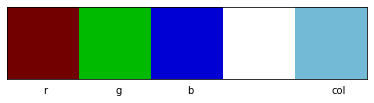

r = 0.45, g = 0.73, b = 0.84


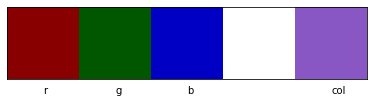

r = 0.54, g = 0.34, b = 0.77


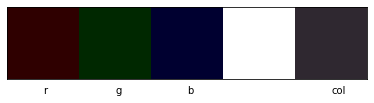

r = 0.19, g = 0.16, b = 0.19


In [16]:
for i in np.arange(3):
    viz_colour_rgb(training_set[i])

You can explore the whole training set with this widget. Move the slider to see different colour data points.

In [17]:
@interact(n=(0,1000))
def interactive_trainset_viz(n):
    c = training_set[n]
    viz_colour_rgb(c)
    

interactive(children=(IntSlider(value=500, description='n', max=1000), Output()), _dom_classes=('widget-intera…

Let's set up the general structure of the neural network. We will create only one layer of pipes, joining each input pipe to each output pipe. This means that we created 3 perceptrons, each with 3 inputs (input r,g,b) and 1 output (r or g or b).

In [18]:
class PipeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3, 3)
        # (3,3) means 3 inputs, 3 outputs


    def forward(self, x):
        x = self.fc1(x)

        return x


net = PipeNet()
untrained_net = copy.deepcopy(net)

After running this, PlumberBot has set up random pipes between the input and the output. This means that the paints won't be mixed correctly. Let's try running our network now.

Input RGB:


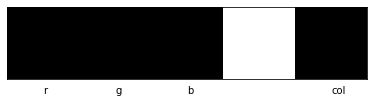

r = 0.0, g = 0.0, b = 0.0

Output Prediction RGB:


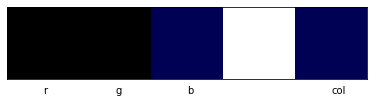

r = -0.29, g = -0.54, b = 0.33
##############################
Input RGB:


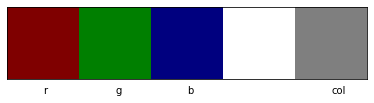

r = 0.5, g = 0.5, b = 0.5

Output Prediction RGB:


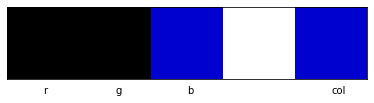

r = -0.26, g = -0.79, b = 0.81
##############################
Input RGB:


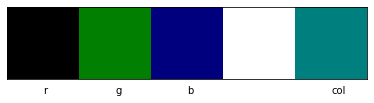

r = 0.0, g = 0.5, b = 0.5

Output Prediction RGB:


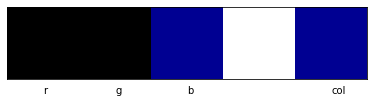

r = -0.2, g = -1.0, b = 0.57
##############################


In [19]:
inputs = torch.as_tensor([0.,0.,0.])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)


inputs = torch.as_tensor([0.5,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)

inputs = torch.as_tensor([0.0,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)

Input RGB:


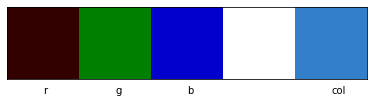

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


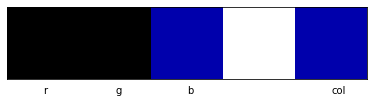

r = -0.11, g = -1.1, b = 0.68
##############################


In [20]:
# Exercise: Fill in col with a colour of your choice, in the form of [r,g,b]. 
# Then, use the neural network to generate the output for that colour.
# Hint: You can pass the input colour as an argument to the net.
# Like this: pred = net(colour)
your_col = [0.2,0.5,0.8] #Fill this
your_col = torch.as_tensor(your_col)

pred_col =  net(your_col)# Fill this
pred_col = pred_col.detach().numpy()

viz_colour_predicted_rgb(your_col,pred_col)

As you can see with the untrained network, the pipes are not connected properly. The output colours are very different from the input colours. Some of the output colours even have negative values, which does not make sense.

Can we measure how different they are? Yes! Let's use the `mse_loss` function you implemented before:


In [21]:
# Exercise: Calculate the difference between the colour you provided and the neural network prediction.
# Hint: You can use your mse_loss function.
# mse_loss(a,b) gives the difference between a and b

your_loss = mse_loss_nb(your_col, pred_col)
print(f"Loss is {your_loss}")

Loss is 2.6561285291535954


For the input colours to be equal to the output colours, the loss has to be 0. 

Let us now ask PlumberBot to train the pipe network.

First we set up the dataset to be in a form that PlumberBot can use:

In [22]:
trainset = ColourDataset(input_data=training_set, output_data=training_set)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

Now we instruct PlumberBot on how to measure the difference between input and output. `nn.MSELoss()` does the same thing as the `mse_loss` function you wrote.

The `optimizer` gives the PlumberBot additional information on how to change the pipes using backpropagation.

In [23]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We now instruct PlumberBot to train the pipe network. PlumberBot will put input data into pipes, look at the outputs, measure the difference and adjust pipes. It will do it 5 times with all the colours we have in our dataset. 

After each time it goes through the dataset, we will print the loss and look at how the output for your colour looks at that point.

[1 Pass through data] loss: 0.114
Input RGB:


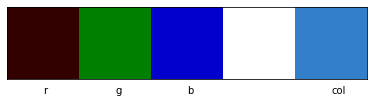

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


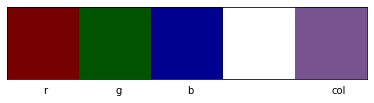

r = 0.47, g = 0.33, b = 0.56
##############################
[2 Pass through data] loss: 0.024
Input RGB:


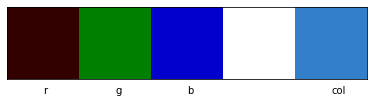

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


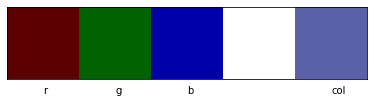

r = 0.36, g = 0.38, b = 0.67
##############################
[3 Pass through data] loss: 0.008
Input RGB:


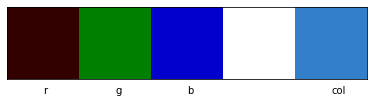

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


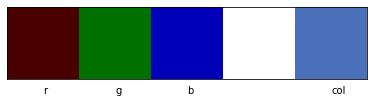

r = 0.29, g = 0.44, b = 0.72
##############################
[4 Pass through data] loss: 0.003
Input RGB:


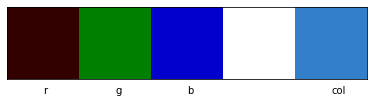

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


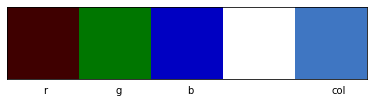

r = 0.25, g = 0.47, b = 0.76
##############################
[5 Pass through data] loss: 0.001
Input RGB:


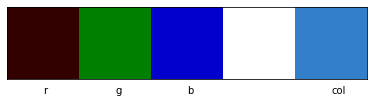

r = 0.2, g = 0.5, b = 0.8

Output Prediction RGB:


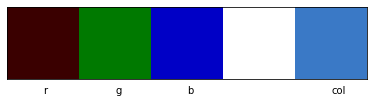

r = 0.23, g = 0.48, b = 0.78
##############################
Finished Training


In [24]:
for epoch in range(5):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    
            print(f'[{epoch + 1} Pass through data] loss: {running_loss/1000 :.3f}')
            running_loss = 0.0
            
            pred_col =  net(your_col)
            pred_col = pred_col.detach().numpy()

            viz_colour_predicted_rgb(your_col,pred_col)

print('Finished Training')

As you can see, as training progresses, the output starts looking more and more similar to your input colour. What is the loss for your colour now?

In [25]:
your_col = torch.as_tensor(your_col)

pred_col =  untrained_net(your_col)
pred_col = pred_col.detach().numpy()

your_loss = mse_loss_nb(your_col, pred_col)
print(f"Loss for untrained network is {your_loss}")

pred_col =  net(your_col)
pred_col = pred_col.detach().numpy()

your_loss = mse_loss_nb(your_col, pred_col)
print(f"Loss for the trained network is {your_loss}")


Loss for untrained network is 2.6561285291535954
Loss for the trained network is 0.0019320284986226424


PlumberBot has done a good job! The loss before training was high, after training, it has become so close to zero. There's almost no difference between the colours.

Let's look at the other sample colours as well:

Input RGB:


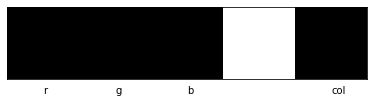

r = 0.0, g = 0.0, b = 0.0

Output Prediction RGB:


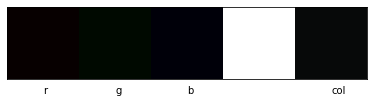

r = 0.028, g = 0.039, b = 0.037
##############################
Input RGB:


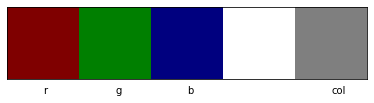

r = 0.5, g = 0.5, b = 0.5

Output Prediction RGB:


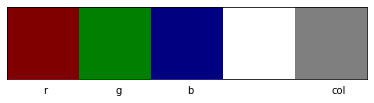

r = 0.5, g = 0.5, b = 0.5
##############################
Input RGB:


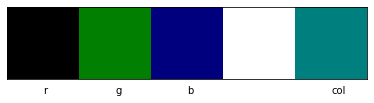

r = 0.0, g = 0.5, b = 0.5

Output Prediction RGB:


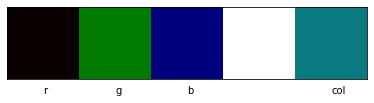

r = 0.038, g = 0.48, b = 0.5
##############################


In [26]:
inputs = torch.as_tensor([0.,0.,0.])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)


inputs = torch.as_tensor([0.5,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)

inputs = torch.as_tensor([0.0,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_rgb(inputs,pred)

Congrats on training your first neural network! Now you understand the basics of how neural networks work. Our first task was not very useful, simply passing the same colours from input to output. Let us make a network for something more useful. But before that, we will take a brief detour to colour land again.

### Colours part 2: CMYK
Now that you know how computers display colours on a screen, let us see how printers print colour on paper. As we discussed in Colours Part 1, the absence of any colour (0 values) is white, the colour of the paper.

Printers use Cyan, Magenta, Yellow and Black ink. This representation is known as CMYK.

![cmyk](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/cmyk-additive-subtractive-colors.jpeg?raw=1)

You can play around with CMYK colours in this widget. It will also display the corresponding RGB representation. We have set k to 0 to show the relationship between cmy and rgb better.


In [27]:
@interact(c=(0, 1.0),m=(0,1.0),y=(0,1.0),k=(0))
def interactive_viz_colour(c,m,y,k):
    print("CMYK:")
    col=[c,m,y,k]
    viz_colour_cmyk(col)
    print("RGB:")
    rgb = cmyk_to_rgb(col)
    viz_colour_rgb(rgb)

interactive(children=(FloatSlider(value=0.5, description='c', max=1.0), FloatSlider(value=0.5, description='m'…

Notice the behaviour of both the colour schemes when you set all c,m,y to 0 and all c,m,y to 1, while keeping k at 0. When c,m,y are 0, the colour produced is white and r,g,b are "on" while c,m,y are "off". When c,m,y are 1, the colour produced is black and r,g,b are "off" and c,m,y are "on".

Let us look at the relationship between the two colour schemes.

For converting RGB to CMYK:

Assuming all our values are between 0 and 1.0, the relationship is:
$$ k = 1 - max(r,g,b) $$
$$ c = (1 - r - k)/ (1 - k) $$
$$ m = (1 - g - k)/ (1 - k) $$
$$ y = (1 - b - k)/ (1 - k) $$

and for converting CMYK to RGB:

$$ r = 1 - (c + k) $$
$$ g = 1 - (m + k) $$
$$ b = 1 - (y + k) $$

Let's implement this in code:


In [28]:
# Exercise: Convert rgb to cmyk
def rgb_to_cmyk_nb(rgb_col):
    r,g,b = rgb_col
    
    ### Your code here
    k = 1 - max(r,g,b)
    c = (1 - r - k)/ (1 - k)
    m = (1 - g - k)/ (1 - k)
    y = (1 - b - k)/ (1 - k)
    ###
    
    cmyk_col = [c,m,y,k]
    return cmyk_col

And let's test it with a sample colour

CMYK:


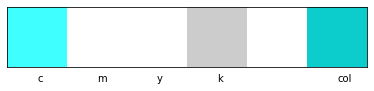

c = 0.75, m = 0.0, y = 0.0, k = 0.2
RGB:


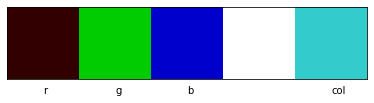

r = 0.2, g = 0.8, b = 0.8


In [29]:
rgb_col = [0.2,0.8,0.8]
cmyk_col = rgb_to_cmyk_nb(rgb_col)

print("CMYK:")
col= cmyk_col
viz_colour_cmyk(col)
print("RGB:")
rgb = rgb_col
viz_colour_rgb(rgb)


In [30]:
# Exercise: Convert cmyk to rgb
def cmyk_to_rgb(cmyk_col):
    c,m,y,k = cmyk_col
    
    ### Your code here
    r = 1 - (c + k)
    g = 1 - (m + k)
    b = 1 - (y + k)
    ###
    
    rgb_col = [r,g,b]
    return rgb_col

And let's test it with a sample colour

CMYK:


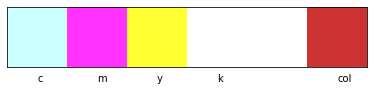

c = 0.2, m = 0.8, y = 0.8, k = 0.0
RGB:


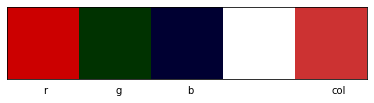

r = 0.8, g = 0.2, b = 0.2


In [31]:
cmyk_col = [0.2,0.8,0.8, 0.0]
rgb_col = cmyk_to_rgb(cmyk_col)

print("CMYK:")
col= cmyk_col
viz_colour_cmyk(col)
print("RGB:")
rgb = rgb_col
viz_colour_rgb(rgb)



Feel free to change the sample colours in the code boxes above and look at how both schemes are converted.

## Network 2: RGB to CMYK

Let us call PlumberBot again. 

![robot 2](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/rp-2.png?raw=1)

This time, we want to input r,g,b paints in our pipeline and get c,m,y,k values back. Let's create the dataset as before

In [32]:
n_size = 1000
rgb_training_set = np.random.rand(n_size,3)
cmyk_training_set = np.asarray(list(map(rgb_to_cmyk, rgb_training_set)))

The slider below shows the pairs of rgb and cmyk:

In [33]:
@interact(n=(0,1000))
def interactive_trainset_viz(n):
    viz_colour_rgb(rgb_training_set[n])
    viz_colour_cmyk(cmyk_training_set[n])
    

interactive(children=(IntSlider(value=500, description='n', max=1000), Output()), _dom_classes=('widget-intera…

Look at the data set size. Notice the rgb has 3 elements each and cmyk has 4 elements each.

In [34]:
print(f"The size of rgb dataset is {rgb_training_set.shape}")
print(f"The size of cmyk dataset is {cmyk_training_set.shape}")

The size of rgb dataset is (1000, 3)
The size of cmyk dataset is (1000, 4)


We need to change our network to handle 3 input pipes and 4 output pipes. 

In [35]:
class PipeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## Exercise: Add the input and output sizes here
        self.fc1 = nn.Linear(3,4)
        # In the previous case, for 3 input and 3 outputs,
        # we used self.fc1 = nn.Linear(3,3), 
        # where first number is input size and second number is output size


    def forward(self, x):
        x = self.fc1(x)
        return x


net = PipeNet()
untrained_net = copy.deepcopy(net)

Lets look at some sample predictions from the untrained net:

Input RGB:


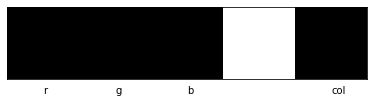

r = 0.0, g = 0.0, b = 0.0

Output Prediction:


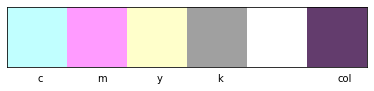

c = 0.24, m = 0.39, y = 0.2, k = 0.37
##############################
Input RGB:


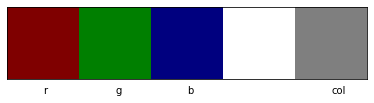

r = 0.5, g = 0.5, b = 0.5

Output Prediction:


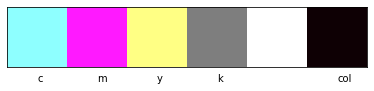

c = 0.44, m = 0.9, y = 0.48, k = 0.5
##############################
Input RGB:


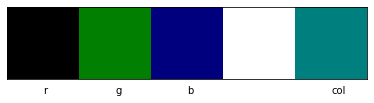

r = 0.0, g = 0.5, b = 0.5

Output Prediction:


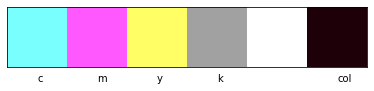

c = 0.52, m = 0.65, y = 0.6, k = 0.36
##############################


In [36]:
inputs = torch.as_tensor([0.,0.,0.])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)


inputs = torch.as_tensor([0.5,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)

inputs = torch.as_tensor([0.0,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)

Input RGB:


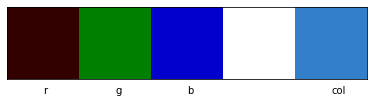

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


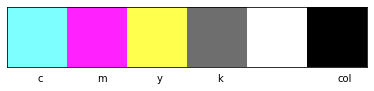

c = 0.51, m = 0.86, y = 0.69, k = 0.57
##############################
Loss is 0.938604212731694


In [37]:
# Exercise: Fill in col with a colour of your choice, in the form of [r,g,b]. 
# Then, use the neural network to generate the output for that colour.
# Hint: You can pass the input colour as an argument to the net.
# Like this: pred = net(colour)
your_col = [0.2,0.5,0.8] #Fill this
your_col = torch.as_tensor(your_col)
true_col = rgb_to_cmyk(your_col)

pred_col =  net(your_col)# Fill thus
pred_col = pred_col.detach().numpy()

viz_colour_predicted_cmyk(your_col,pred_col)

your_loss = np.sum((true_col - pred_col) **2)
print(f"Loss is {your_loss}")

As you can see, the untrained network gives wrong predictions with a high loss.

We need to ask PlumberBot to train the network, similar to the procedure in the previous problem.

In [38]:
trainset = ColourDataset(input_data=rgb_training_set, output_data=cmyk_training_set)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[4 Pass through data] loss: 0.019
Input RGB:


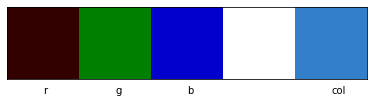

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


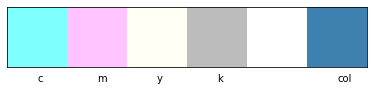

c = 0.49, m = 0.23, y = 0.044, k = 0.26
##############################
[8 Pass through data] loss: 0.014
Input RGB:


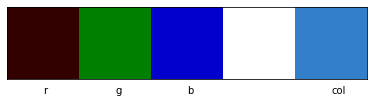

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


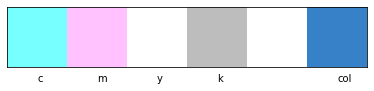

c = 0.53, m = 0.24, y = -0.041, k = 0.26
##############################
[12 Pass through data] loss: 0.014
Input RGB:


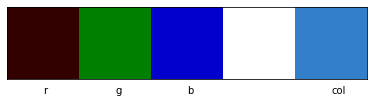

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


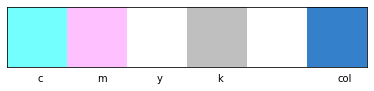

c = 0.54, m = 0.25, y = -0.05, k = 0.25
##############################
[16 Pass through data] loss: 0.014
Input RGB:


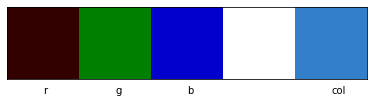

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


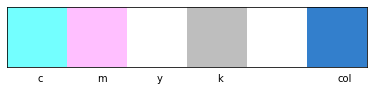

c = 0.55, m = 0.25, y = -0.052, k = 0.25
##############################
[20 Pass through data] loss: 0.014
Input RGB:


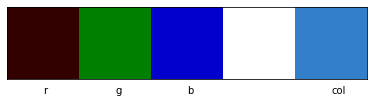

r = 0.2, g = 0.5, b = 0.8

Output Prediction:


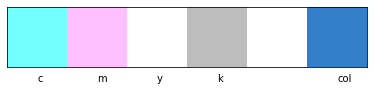

c = 0.54, m = 0.24, y = -0.056, k = 0.26
##############################
Finished Training


In [39]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999 and epoch % 4 == 3:    
            print(f'[{epoch + 1} Pass through data] loss: {running_loss/1000 :.3f}')
            running_loss = 0.0
            
            pred_col =  net(your_col)
            pred_col = pred_col.detach().numpy()

            viz_colour_predicted_cmyk(your_col,pred_col)

print('Finished Training')

Let's look at the prediction for our input rgb colour:

In [40]:
your_col = torch.as_tensor(your_col)

pred_col =  untrained_net(your_col)
pred_col = pred_col.detach().numpy()

your_loss = np.sum((true_col - pred_col) **2)
print(f"Loss for untrained network is {your_loss}")

pred_col =  net(your_col)
pred_col = pred_col.detach().numpy()

your_loss = np.sum((true_col - pred_col) **2)
print(f"Loss for the trained network is {your_loss}")



Loss for untrained network is 0.938604212731694
Loss for the trained network is 0.012380864797272366


The loss is much closer to 0 now. Our sample colours look much better now too:

Input RGB:


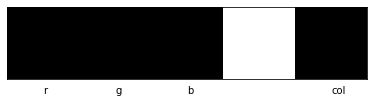

r = 0.0, g = 0.0, b = 0.0

Output Prediction:


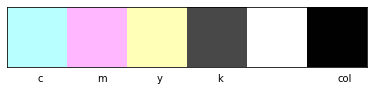

c = 0.28, m = 0.28, y = 0.28, k = 0.72
##############################
Input RGB:


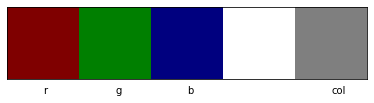

r = 0.5, g = 0.5, b = 0.5

Output Prediction:


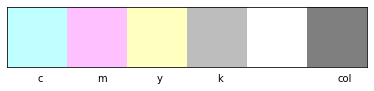

c = 0.24, m = 0.24, y = 0.24, k = 0.25
##############################
Input RGB:


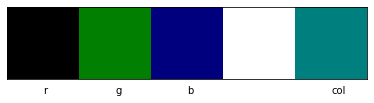

r = 0.0, g = 0.5, b = 0.5

Output Prediction:


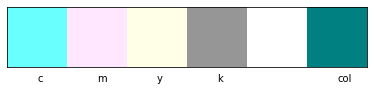

c = 0.59, m = 0.087, y = 0.087, k = 0.41
##############################


In [41]:

inputs = torch.as_tensor([0.,0.,0.])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)


inputs = torch.as_tensor([0.5,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)

inputs = torch.as_tensor([0.0,0.5,0.5])
pred = net(inputs).detach().numpy()
viz_colour_predicted_cmyk(inputs,pred)

Good job again PlumberBot!
We have learnt how to create simple neural networks, and the basics of how they work.

### Plot twist
Did you know that the images of PlumberBot was created using a neural network?

That model is called Dall E mini, and it can generate images from any text you provide it.

Here are some more examples of "Robot plumber fixing neural networks":

![robot 1](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/rp-3.png?raw=1)
![robot 2](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/res/fig/rp-4.png?raw=1)

You can generate your own images here: https://huggingface.co/spaces/dalle-mini/dalle-mini
(Hint: If it shows an error, close the error and click on run again till it works. It will take a minute or two to generate images)

## Optional Challenge: CMYK to RGB Network
Can you create a network to convert CMYK values to RGB values? Feel free to copy any code from above.

In [42]:
n_size = 1000
rgb_training_set = np.random.rand(n_size,3)
cmyk_training_set = np.asarray(list(map(rgb_to_cmyk, rgb_training_set)))

In [43]:
class PipeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## Exercise: Add the input and output sizes here
        self.fc1 = nn.Linear(4,3)
        # In the previous case, for 3 input and 3 outputs,
        # we used self.fc1 = nn.Linear(3,3), 
        # where first number is input size and second number is output size


    def forward(self, x):
        x = self.fc1(x)
        return x


net = PipeNet()
untrained_net = copy.deepcopy(net)

In [44]:
trainset = ColourDataset(input_data=cmyk_training_set, output_data=rgb_training_set)

batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999 and epoch % 4 == 3:    
            print(f'[{epoch + 1} Pass through data] loss: {running_loss/1000 :.3f}')
            running_loss = 0.0
            

print('Finished Training')

[4 Pass through data] loss: 0.023
[8 Pass through data] loss: 0.009
[12 Pass through data] loss: 0.004
[16 Pass through data] loss: 0.002
[20 Pass through data] loss: 0.001
Finished Training
